# North Atlantic Hurricanes
The learning objectives of this notebook are to carry out feature selection for a classification model, train a classification model for types of hurricanes, and understand outcomes of feature uncertainty based on a experiment.

The [North Atlantic Hurricanes dataset](https://myweb.fsu.edu/jelsner/temp/Data.html) used is developed by James B. Elsner and colleagues containing hurricanes recorded during the years 1944 to 2000. Each hurricane instance contains the year, the name (if it was named), the coordinates where it started, the last coordinates measured, the maximum coordinates (based on an aspect that an increment means closer to the coast), the maximum intensity, and the type. They are labeled into 3 types: tropical hurricanes (Type 0), hurricanes under baroclinic influences (Type 1), and hurricanes from baroclinic initiation (Type 3).

Let's start with loading the data.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_FOLDER = Path("..") / "data"
DATA_FILEPATH = DATA_FOLDER / "hurricanes.csv"
# Execute on cloud platform? (e.g. colab), try this path instead
# DATA_FILEPATH = "https://raw.githubusercontent.com/jeepchinnawat/edumat-book/main/data/hurricanes.csv"

hurricanes = pd.read_csv(DATA_FILEPATH)
hurricanes

,RowNames,Number,Name,Year,Type,FirstLat,FirstLon,MaxLat,MaxLon,LastLat,LastLon,MaxInt
0,1,430,NOTNAMED,1944,1,30.2,-76.1,32.1,-74.8,35.1,-69.2,80
1,2,432,NOTNAMED,1944,0,25.6,-74.9,31.0,-78.1,32.6,-78.2,80
2,3,433,NOTNAMED,1944,0,14.2,-65.2,16.6,-72.2,20.6,-88.5,105
3,4,436,NOTNAMED,1944,0,20.8,-58.0,26.3,-72.3,42.1,-71.5,120
4,5,437,NOTNAMED,1944,0,20.0,-84.2,20.6,-84.9,19.1,-93.9,70
...,...,...,...,...,...,...,...,...,...,...,...,...
332,333,1227,GORDON,2000,1,25.2,-85.4,26.1,-84.9,28.0,-83.8,70
333,334,1229,ISAAC,2000,0,14.3,-33.2,26.6,-54.2,39.7,-47.9,120
334,335,1230,JOYCE,2000,0,12.4,-38.8,12.2,-42.5,10.5,-48.6,80
335,336,1231,KEITH,2000,0,17.9,-86.4,17.9,-87.2,22.6,-97.9,120


## Introductory Data Inspection

In [2]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RowNames  337 non-null    int64  
 1   Number    337 non-null    int64  
 2   Name      337 non-null    object 
 3   Year      337 non-null    int64  
 4   Type      337 non-null    int64  
 5   FirstLat  337 non-null    float64
 6   FirstLon  337 non-null    float64
 7   MaxLat    337 non-null    float64
 8   MaxLon    337 non-null    float64
 9   LastLat   337 non-null    float64
 10  LastLon   337 non-null    float64
 11  MaxInt    337 non-null    int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 31.7+ KB


We will leave out the year and go on with first, last, and maximum cooridinates and maximum intensity as our potential fields for classification task.

In [3]:
features = ['FirstLat','FirstLon','MaxLat','MaxLon','LastLat','LastLon','MaxInt']
label = ['Type']

We can look at simple statistics of our features with `describe` function of pandas' dataframe.

In [4]:
hurricanes[features].describe()

,FirstLat,FirstLon,MaxLat,MaxLon,LastLat,LastLon,MaxInt
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,23.437982,-65.568546,27.198220,-68.650742,34.550148,-64.895252,94.572700
std,7.592829,17.665280,7.724416,16.875719,10.175473,22.074126,23.287442
min,10.300000,-96.700000,10.300000,-98.400000,10.000000,-99.200000,65.000000
25%,16.600000,-80.000000,21.700000,-82.500000,28.700000,-83.500000,75.000000
50%,23.300000,-65.300000,27.300000,-68.400000,35.500000,-65.600000,90.000000
75%,28.700000,-53.400000,33.000000,-56.800000,42.100000,-48.500000,110.000000
max,46.000000,-23.000000,48.000000,-7.500000,61.100000,-5.000000,165.000000


Simply replacing `describe` with `boxplot` function, we can visualize some of stats above with box plot.

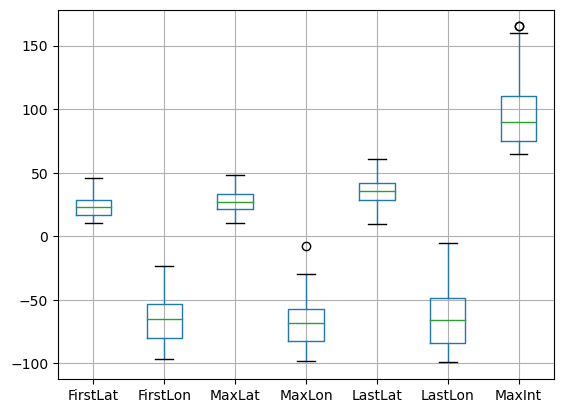

In [5]:
hurricanes[features].boxplot()
plt.show()

## Feature Selection
In learning and working on machine learning or data science models in general, the size of the dataset can vary greatly. Large datasets refer to those containing a large number of data instances, a large number of features, or both. However, datasets containing a large number of features, also called a high dimensional datasets, present unique challenges because the larger they are, the bigger the feature space and the longer it takes algorithms to find the optimal solution to predict target variables. The inclusion of irrelevant and unimportant features can also negatively impact the performance of the model.

Although the hurricane dataset we are working with is not very large, we can take this chance to apply feature selection methods to find the two most optimal features that will go into our classification model. Doing so will make it more convenient to visualize figures for a predictor on 2D plots. The following sections demonstrate two feature selection techniques including univariate selection and Random Forrest's feature importances.

### Univariate Selection

Statistical tests can be used to check how well each feature discriminates between classes of a target (categorical) variable. To quantify such tests, we use scikit-learn's ANOVA (analysis of variance) F-value `f_classif` together with `SelectKBest` to select features according to the k highest scores, in our case 2.

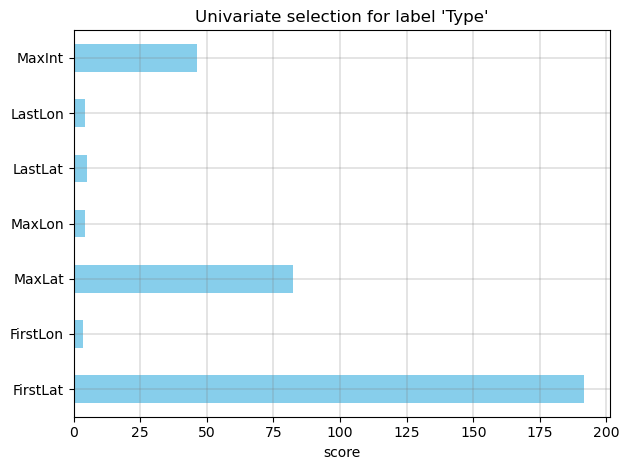

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

f_test = SelectKBest(f_classif, k=2)
f_test.fit(hurricanes[features], hurricanes[label[0]])
scores = f_test.scores_

features_scores = pd.Series(scores, index=features)

fig, ax = plt.subplots()
features_scores.plot.barh(ax=ax, color='skyblue')
ax.grid(True, which='both', color='grey', linewidth=0.3)
ax.set_title("Univariate selection for label 'Type'")
ax.set_xlabel("score")
fig.tight_layout()
plt.show()

#### Intuition
To understand how these statistical tests quantify features' discriminating scores, we plot the distributions of each hurricane type toward the feature with highest score `FirstLat` and the least one `FirstLon`.

The graph shows that, even though the projected distributions onto `FirstLat` do not clearly discriminate between the 3 classes, they do much better than those of `FirstLon` where all class distributions are completely overlapped onto each other.

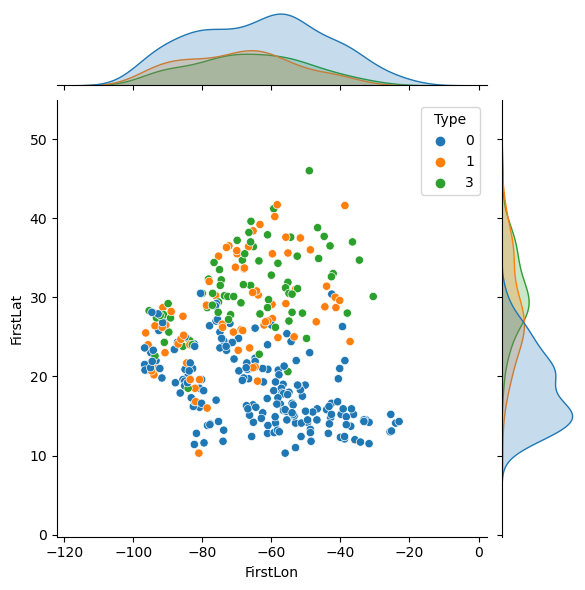

In [7]:
import seaborn as sns

sns.jointplot(data=hurricanes, x="FirstLon", y="FirstLat", hue="Type", palette="tab10")
plt.show()

### Random Forest's Feature Importance
A Random Forest can be used to estimate the importances of features on a particular task. The importance of a feature is measured by looking the mean decrease in impurity, or the degree to which the tree nodes using that feature are able to reduce impurity (Gini or Shannon information gain) across all trees in the forest on average.

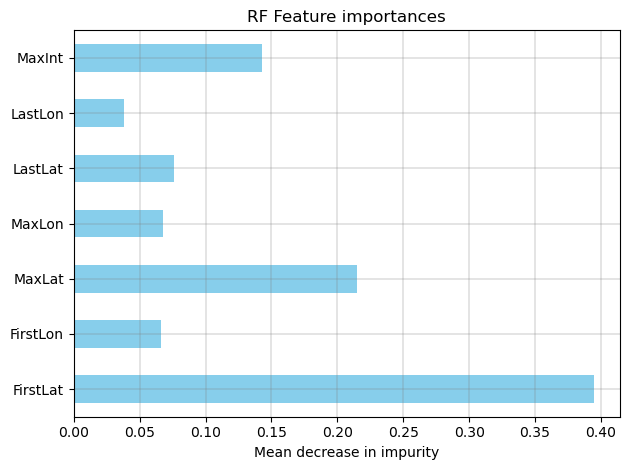

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_jobs=2, min_samples_leaf=1,
                            max_depth=4, max_features=2, min_samples_split=2, n_estimators=40)
rf.fit(hurricanes[features], hurricanes[label[0]])

importances = rf.feature_importances_
features_scores = pd.Series(importances, index=features)

fig, ax = plt.subplots()
features_scores.plot.barh(ax=ax, color='skyblue')
ax.grid(True, which='both', color='grey', linewidth=0.3)
ax.set_title("RF Feature importances")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

These results reflect an agreement between the two feature selection techniques, in that both methods selected first latitude, maximum latitude, and maximum intensity (`FirstLat`, `MaxLat`, and `MaxInt`) as the most optimal features for predicting the hurricane type.

In [9]:
selected_features = ['FirstLat', 'MaxLat', 'MaxInt']

However, our goal is to have two features. The intuitive choice might be to simply pick the two highest scored features: `FirstLat` and `MaxLat`, but this strategy might result in the selection of redundant features.

Feature Correlation is a useful approach that can be taken to further eliminate the less relevant features.

## Feature Correlation
When two features are highly correlated, they are considered to provide the same knowledge about the target variables or labels, and therefore it is redundant to include both in a model.

`FirstLat` and `MaxLat` are highly correlated. The data instances projected into both feature spaces also distribute toward our target variable `Type` very similarly.

To avoid this redundancy, we will instead build the classification model with the features `FirstLat` and `MaxInt`.

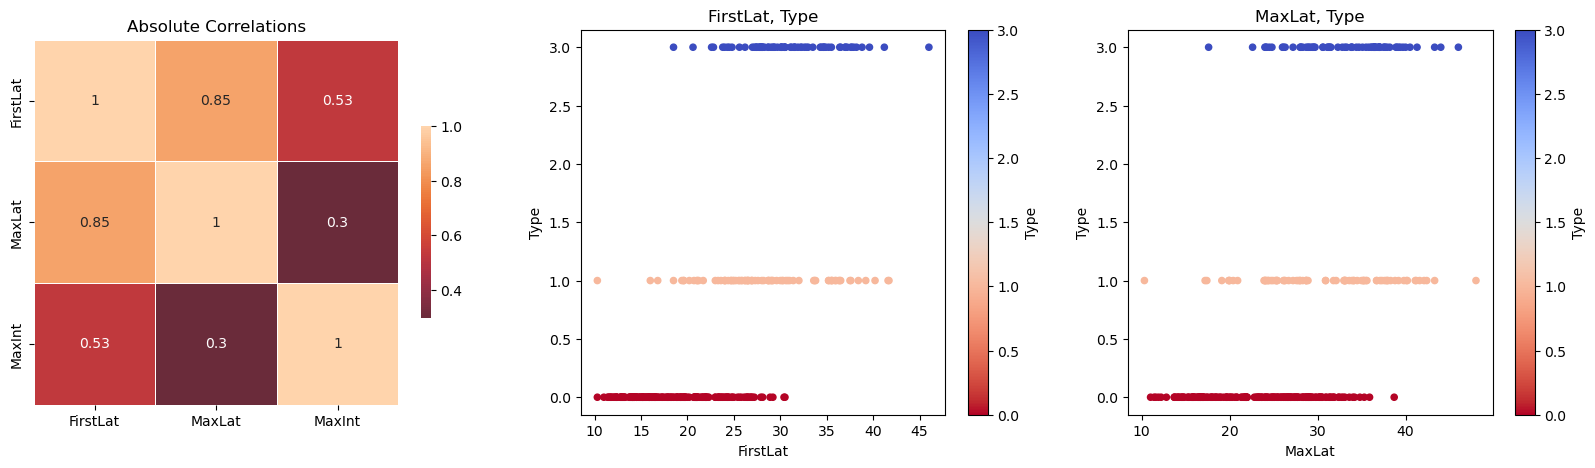

In [10]:
import seaborn as sns

fig, axs = plt.subplots(1,3, figsize=(20, 5))

# the abs. correlation matrix
df = pd.DataFrame(hurricanes, columns=selected_features)
abs_corr = df.corr().abs()
sns.heatmap(abs_corr, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axs[0])
axs[0].set_title("Absolute Correlations")

hurricanes.plot.scatter('FirstLat', 'Type', c='Type', colormap='coolwarm_r', ax=axs[1])
axs[1].set_title("FirstLat, Type")

hurricanes.plot.scatter('MaxLat', 'Type', c='Type', colormap='coolwarm_r', ax=axs[2], sharey=axs[1])
axs[2].set_title("MaxLat, Type")

plt.show()

In [11]:
selected_features = ['FirstLat', 'MaxInt']

## Stratified Data Splitting

When we plot the training samples according to Type, we see that there are a disproportionate samples for hurricanes of Type 0, with fewer hurricanes representing Type 1 and Type 3.

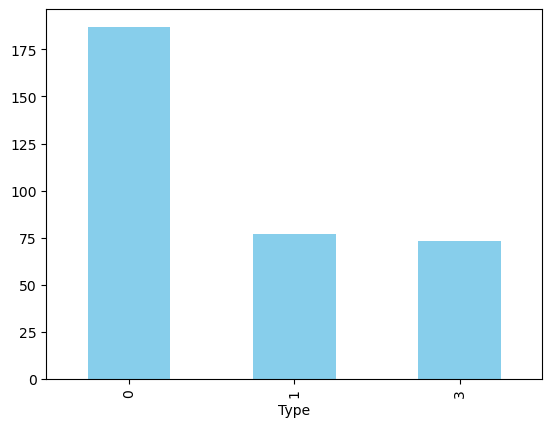

In [12]:
hurricanes.groupby('Type').Type.count().plot(kind='bar', color='skyblue')
plt.show()

This could present a problem during training, because if we randomly sample the entire dataset, there is a chance that we will overselect Type 0 while failing to select enough Type 1 and Type 3. Such imbalances in the training samples could result in a model that has high prediction accuracy for Type 0 hurricanes, and low accuracy for the other types.

To combat this issue, we can introduce stratification. Rather than randomly sampling from the entire dataset, stratification instead randomly samples from each strata (in this case, each Type) to achieve an adequate representation.

In [13]:
from sklearn.model_selection import train_test_split

X,y = hurricanes[selected_features].copy(), hurricanes[label[0]].copy()
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=.7, random_state=0, stratify=y)

## Classification Model

Support Vector Machines (SVMs) determine the hyperplane(s) that best separates the dataset into different categories. This is done, for example, by finding the hyperplane defined by the largest possible margin between data points in different categories.

Here, the SVM is classified using C-Support Vector Classification (SVC), in order to handle multi-class classification. The “C” in the name refers to the penalty parameter of the error term.

The features are also preprocessed to a 0 mean and unit variance by using the Standard Scaler. This is an important step because SVMs are not scale invariant.

Two arrays are required for the input to the SVM: an array of training samples and an array of class labels.

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

svm.fit(X_train, y_train)
svm.score(X_train, y_train)

0.723404255319149

The SVM score indicates the mean accuracy of the predictions.

In [15]:
svm.score(X_test, y_test)

0.696078431372549

In addition to seeing the score, we can also visualize the accuracy using a Confusion Matrix. It contains information about True Positives, True Negatives, False Positives and False Negatives, which in turn enable us to compute the precision and recall of the model.

We can see from the Confusion Matrix that Type 0 hurricanes are estimated with the highest accuracy, while Type 1 hurricanes were often predicted as Type 3. This indicates that the hyperplane between Type 0 and the other types was better learned than the hyperplane between Type 1 and 3.

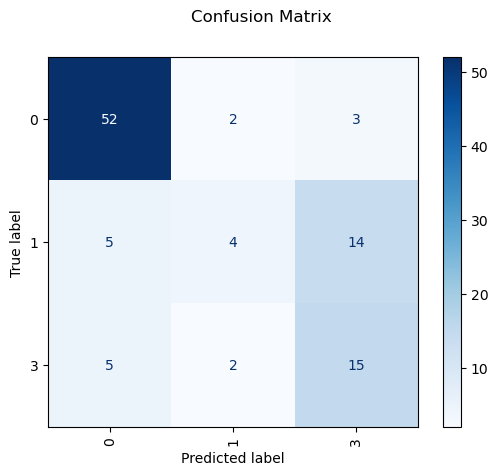

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = svm.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation = 'vertical',
                                               cmap=plt.cm.Blues)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### Transform to binary classification
- Tropical-or-not classification since the previous model is pretty good at prediction tropical hurricanes.

As seen in the previous steps, the model predicts Type 0 tropical hurricanes well, but has difficulty distinguishing between Type 1 hurricanes under baroclinic influences, and Type 3 hurricanes from baroclinic initiation.

Thus, we will revise the model from a multi-class classification to a binary classification that distinguishes between tropical and non-tropical hurricanes.

In [17]:
tropical = hurricanes.copy()

# merge type 3 into type 1 for binary classification problem (tropical hurricane or not?)
tropical.loc[tropical['Type'] == 3, 'Type'] = 1
# check for binary type
tropical['Type'].unique()

array([1, 0])

The Type 1 and Type 3 data samples are merged into a single type, and we perform a new train test split of the binary dataset.

In [18]:
X,y = tropical[selected_features].copy(), tropical[label[0]].copy()
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=.7, random_state=0, stratify=y)

In [19]:
import matplotlib.patches

def plot_2DClassifier(X, f, y, classifier, title):
    # create a predicted mesh
    s = 0.2
    f1, f2 = f[0], f[1]
    x_min, x_max = X[f1].min() - 1, X[f1].max() + 1
    y_min, y_max = X[f2].min() - 1, X[f2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, s), np.arange(y_min, y_max, s))
    df = {f1: xx.ravel(),f2: yy.ravel()}
    xy = pd.DataFrame(df)
    Z = classifier.predict(xy)
    fig, ax = plt.subplots()

    # Fill the plot with predicted mesh
    levels, categories = pd.factorize(Z, sort=True)
    levels = levels.reshape(xx.shape)
    ax.contourf(xx, yy, levels, cmap=plt.cm.coolwarm, alpha=0.3)

    # data scatter plot
    n_classes = classifier.classes_.shape[0]
    levels, categories = pd.factorize(y, sort=True)
    handles = [matplotlib.patches.Patch(color=plt.cm.coolwarm.resampled(n_classes)(i), label=c) for i, c in enumerate(categories)]
    ax.scatter(X[f1], X[f2], c=levels, cmap=plt.cm.coolwarm, edgecolors='black')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(title)
    ax.legend(handles=handles, title='Type')
    plt.show()

### SVM for binary classification
- with interactive hyperparameters w/ ipywidgets

The hyperparameters of SVM (C and gamma) can be tuned using this widget to visualize how they effect the model results.

C is a regularization parameter that determines the smoothness of the boundary between the categories. A larger C results in a larger proportion of correctly classified training samples, but the decision surface is less smooth and the margin is smaller. A smaller C results in a smoother decision boundary and larger margin at the expense of some misclassified samples.

The gamma value determines the radius of influence of a single training sample. A small gamma value gives a single training point a wider radius of influence, with faraway points exerting higher influence. A large gamma value require that points be relatively close together to be included in the same category, with nearer points exerting a higher influence.

Generally speaking, excessively high values result in overfitting, and excessively low values result in underfitting.

In [20]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

def svc_interact(C, gamma, model):
    status_widget.value = 'Calculating...'

    model.named_steps.svc.set_params(**{'C': C, 'gamma': gamma})

    model.fit(X_train, y_train)
    plot_2DClassifier(X_train, selected_features, y_train, model, "SVM w/ training set")

    status_widget.value = f'Test set accuracy : {model.score(X_test, y_test)}'

C_widget = widgets.FloatLogSlider(value=10., min=-3, max=2, base=10, step=0.2, description='C:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f')
gamma_widget = widgets.FloatLogSlider(value=0.25, min=-3, max=2, base=10, step=0.2, description='Gamma:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f')
status_widget = widgets.Label(value='')

bi_svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

interact(svc_interact, C=C_widget, gamma=gamma_widget, model=fixed(bi_svm))
display(status_widget)

interactive(children=(FloatLogSlider(value=10.0, continuous_update=False, description='C:', max=2.0, min=-3.0,…

Label(value='Test set accuracy : 0.8235294117647058')

## Feature uncertainty experiment
- Assume above the decision boundary(model) as a model a data annotator uses to label trocical hurricanes
- features X also as true measurements
- Re-classify X with the model to have truely annotated labels (wrt. an annotator)

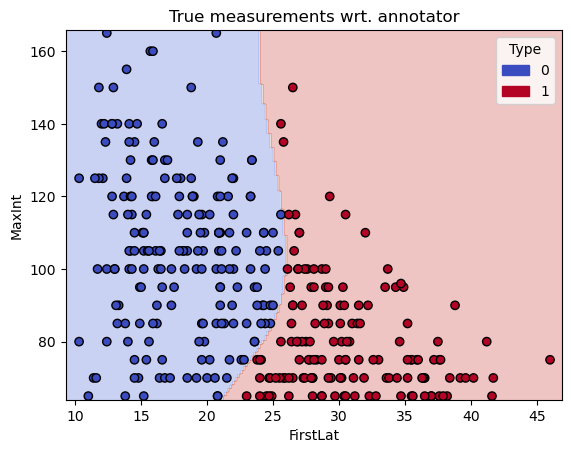

In [21]:
true_y = bi_svm.predict(X)

plot_2DClassifier(X, selected_features, true_y, bi_svm, "True measurements wrt. annotator")

### Add Gaussian noise to features
- Expected: Affecting data points in the vicinity of decision boundaries to be the mislabeled data instances

In [22]:
def noise_interact(sd):
    status_widget.value = 'Calculating...'
    noisy_X = X + np.random.normal(loc=0.0, scale=sd, size=X.shape)

    plot_2DClassifier(noisy_X, selected_features, true_y, bi_svm, "Noisy measurement wrt. annotator")

    noisy_pred = bi_svm.predict(noisy_X)
    status_widget.value = f"Noisy inputs accuracy: {bi_svm.score(noisy_X, true_y)}"

sd_widget = widgets.FloatSlider(value=1., min=0.1, max=5., step=0.1, description='SD :',
    disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'
)
status_widget = widgets.Label(value='')

interact(noise_interact, sd=sd_widget)
display(status_widget)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='SD :', max=5.0, min=0.1, re…

Label(value='Noisy inputs accuracy: 0.9673590504451038')